In [188]:
import pandas as pd
import numpy as np
import nltk
import string

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import itertools
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram, ward
from scipy.spatial.distance import pdist, squareform

#from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score



Lecture: https://github.com/GalvanizeDataScience/lectures/blob/SF/clustering/clustering.ipynb

Lecture: https://github.com/gSchool/DSI_Lectures/blob/master/clustering/mark_llorente/clustering_lecture.ipynb

Assignment: https://github.com/mrdtirado/clustering

## Understanding the Centroids from K-Means
K-means' centroids represent the average or typical observation in each cluster, and examining the centroids can shed light on the essential traits or identity of each observation. For example, k-means applied to the MNIST digit dataset reveals the "average" digits:


Applying K-means to TF-IDF or bag-of-words features produces topic centroids. For this sprint, you will perform topic modeling on news articles using k-means and hierarchical clustering.

1. Apply kmeans clustering to the `articles.pkl`. Use pandas' `pd.read_pickle()`. 

In [2]:
df_original = pd.read_pickle('/home/asus/G_school_lectures/Week_7_Lectures/clustering/data/articles.pkl')

In [3]:
df = df_original.copy()

In [4]:
df_original.shape

(1405, 15)

In [5]:
df.head()

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content
0,article,http://www.nytimes.com/2013/10/03/sports/footb...,You would think that in a symmetric zero-sum s...,None,You would think that in a symmetric zero-sum s...,Sports,347,The New York Times,Sports,Pro Football,524d4e3a38f0d8198974001f,2013-10-03T00:00:00Z,None,Week 5 Probabilities: Why Offense Is More Impo...,the original goal building model football fore...
1,article,http://www.nytimes.com/2013/10/03/us/new-immig...,House Democrats on Wednesday unveiled an immig...,House Democrats unveil immigration bill that p...,House Democrats on Wednesday unveiled an immig...,National,83,The New York Times,U.S.,None,524cf71338f0d8198973ff7b,2013-10-03T00:00:00Z,21,New Immigration Bill Put Forward,house unveiled immigration bill provides path ...
2,article,http://www.nytimes.com/2013/10/03/us/arizona-j...,A federal judge on Wednesday ordered the appoi...,Federal Judge Murray Snow orders the appointme...,A federal judge on Wednesday ordered the appoi...,National,160,The New York Times,U.S.,None,524cf50e38f0d8198973ff79,2013-10-03T00:00:00Z,21,Arizona: Judge Orders Monitor to Oversee Maric...,federal judge wednesday ordered appointment in...
3,article,http://www.nytimes.com/2013/10/03/us/texas-sta...,Texas has turned to a compounding pharmacy to ...,"Documents show that Texas, nation's most activ...",Texas has turned to a compounding pharmacy to ...,National,112,The New York Times,U.S.,None,524cf39a38f0d8198973ff78,2013-10-03T00:00:00Z,21,Texas: State Bought Execution Drugs From a Com...,texas nation’s active death-penalty state turn...
4,article,http://www.nytimes.com/2013/10/03/sports/tenni...,"Rafael Nadal, aiming to end Novak Djokovic’s r...",None,"Rafael Nadal, aiming to end Novak Djokovic’s r...",Sports,49,The New York Times,Sports,Tennis,524cf28b38f0d8198973ff73,2013-10-03T00:00:00Z,14,Nadal on Track for No. 1 Spot,rafael nadal aiming end novak djokovic’s run 1...


Applying K-means to TF-IDF or bag-of-words features produces topic centroids. For this sprint, you will perform topic modeling on news articles using k-means and hierarchical clustering.

In [6]:
df = df[['content', '_id']]

In [7]:
df.head()

,content,_id
0,the original goal building model football fore...,524d4e3a38f0d8198974001f
1,house unveiled immigration bill provides path ...,524cf71338f0d8198973ff7b
2,federal judge wednesday ordered appointment in...,524cf50e38f0d8198973ff79
3,texas nation’s active death-penalty state turn...,524cf39a38f0d8198973ff78
4,rafael nadal aiming end novak djokovic’s run 1...,524cf28b38f0d8198973ff73


In [8]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [9]:
def text_pipeline(doc, stops= {}, lemmatize= False, stem=False):
    '''
    Args:
        doc (str): the text to be tokenized
        stops (set): an optional set of words (tokens) to exclude
        lemmatize (bool): if True, lemmatize the words

    Returns: 
        tokens (list of strings)
    '''
    # sets all characters to lowercase and splits them into words
    doc = doc.lower().split()
    
    # to remove punctuation 
    punct = set(string.punctuation)
    
    # antiquated to remove everything but ascii letters
    alpha = set(string.ascii_lowercase)
    
    # grab tokens character by character if they are lowercase letters
    tokens = [''.join([char for char in tok if char in alpha])
             for tok in doc]
    # if token checks if token is in tokens through a boolean but 
    # empty strings and lists are automatically False
    tokens = [token for token in tokens if token]
    
    if stops:
        tokens = [tok for tok in tokens if (tok not in stops)]
    if lemmatize:
        lemmatize = WordNetLemmatizer() 
        token = [lemmatizer.lemmatize(tok) for tok in tokens]
    if stem:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(tok) for tok in tokens]
    return tokens


In [10]:
corpus = df['content'].values

In [11]:
vectorizer = CountVectorizer(lowercase=True, stop_words=stop_words,tokenizer=text_pipeline)

In [12]:
X = vectorizer.fit_transform(corpus)

/home/asus/.virtualenvs/gurus/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
vocab = vectorizer.get_feature_names()

In [14]:
X_count = X.toarray()

In [15]:
len(X_count)

1405

In [16]:
X_count.shape

(1405, 38220)

In [17]:
X_count

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
count_vectors = pd.DataFrame(data=X_count, columns=vocab)
count_vectors

,aa,aaa,aadvantage,aardsma,aaron,ab,aba,abandon,abandoned,abandoning,...,zuerlein,zuhur,zullo,zullos,zuo,zurich,zweibel,zwerling,zwinak,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dfword = np.count_nonzero(X_count, axis=0) / len(X_count)

In [20]:
dfword

array([0.00213523, 0.00427046, 0.00071174, ..., 0.00142349, 0.00071174,
       0.00071174])

In [21]:
dfword.shape

(38220,)

In [22]:
idfword = np.log(1/dfword)

In [23]:
tfidf = X_count*idfword

In [24]:
tfidf.shape

(1405, 38220)

In [27]:
count_vectors = pd.DataFrame(data=tfidf, columns=vocab)
count_vectors

,aa,aaa,aadvantage,aardsma,aaron,ab,aba,abandon,abandoned,abandoning,...,zuerlein,zuhur,zullo,zullos,zuo,zurich,zweibel,zwerling,zwinak,zz
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply kmeans clustering to the articles.pkl. Use pandas' pd.read_pickle(). Use either the kmeans you implemented or scikit-learn's module if you did not finish your implementation.

In [28]:
kmeans = KMeans(n_clusters=8).fit(tfidf)

In [29]:
kmeans.labels_

array([5, 5, 5, ..., 5, 1, 4], dtype=int32)

2. To find out what "topics" Kmeans has discovered we must inspect the centroids.  Print out the centroids of the Kmeans clustering.
   
   These centroids are simply a bunch of vectors.  To make any sense of them we need to map these vectors back into our 'word space'.  Think of each feature/dimension of the centroid vector as representing the "average" article or the average occurrences of words for that cluster.

In [30]:
clusters = kmeans.cluster_centers_

In [36]:
df_original

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content
0,article,http://www.nytimes.com/2013/10/03/sports/footb...,You would think that in a symmetric zero-sum s...,None,You would think that in a symmetric zero-sum s...,Sports,347,The New York Times,Sports,Pro Football,524d4e3a38f0d8198974001f,2013-10-03T00:00:00Z,None,Week 5 Probabilities: Why Offense Is More Impo...,the original goal building model football fore...
1,article,http://www.nytimes.com/2013/10/03/us/new-immig...,House Democrats on Wednesday unveiled an immig...,House Democrats unveil immigration bill that p...,House Democrats on Wednesday unveiled an immig...,National,83,The New York Times,U.S.,None,524cf71338f0d8198973ff7b,2013-10-03T00:00:00Z,21,New Immigration Bill Put Forward,house unveiled immigration bill provides path ...
2,article,http://www.nytimes.com/2013/10/03/us/arizona-j...,A federal judge on Wednesday ordered the appoi...,Federal Judge Murray Snow orders the appointme...,A federal judge on Wednesday ordered the appoi...,National,160,The New York Times,U.S.,None,524cf50e38f0d8198973ff79,2013-10-03T00:00:00Z,21,Arizona: Judge Orders Monitor to Oversee Maric...,federal judge wednesday ordered appointment in...
3,article,http://www.nytimes.com/2013/10/03/us/texas-sta...,Texas has turned to a compounding pharmacy to ...,"Documents show that Texas, nation's most activ...",Texas has turned to a compounding pharmacy to ...,National,112,The New York Times,U.S.,None,524cf39a38f0d8198973ff78,2013-10-03T00:00:00Z,21,Texas: State Bought Execution Drugs From a Com...,texas nation’s active death-penalty state turn...
4,article,http://www.nytimes.com/2013/10/03/sports/tenni...,"Rafael Nadal, aiming to end Novak Djokovic’s r...",None,"Rafael Nadal, aiming to end Novak Djokovic’s r...",Sports,49,The New York Times,Sports,Tennis,524cf28b38f0d8198973ff73,2013-10-03T00:00:00Z,14,Nadal on Track for No. 1 Spot,rafael nadal aiming end novak djokovic’s run 1...
5,article,http://www.nytimes.com/2013/10/03/sports/socce...,A Brazilian labor judge ordered the suspension...,None,A Brazilian labor judge ordered the suspension...,Sports,49,The New York Times,Sports,Soccer,524ced7138f0d8198973ff67,2013-10-03T00:00:00Z,14,Judge Halts Work on World Cup Stadium,brazilian labor judge ordered suspension const...
6,article,http://www.nytimes.com/2013/10/03/sports/socce...,Defending champion Bayern Munich produced a po...,"Bayern Munich beats Manchester City, 3-1, in U...",Defending champion Bayern Munich produced a po...,Sports,190,The New York Times,Sports,Soccer,524ce87638f0d8198973ff59,2013-10-03T00:00:00Z,14,Bayern Munich Dominates Manchester City,defending champion bayern munich produced powe...
7,article,http://www.nytimes.com/2013/10/03/sports/ameri...,Simone Biles used superb floor and vault exerc...,American Simone Biles sweeps past teammate Kyl...,Simone Biles used superb floor and vault exerc...,Sports,49,The New York Times,Sports,None,524cebfb38f0d8198973ff5f,2013-10-03T00:00:00Z,14,American Leads in World Gymnastics All-Around,simone bile used superb floor vault exercise s...
8,article,http://www.nytimes.com/2013/10/03/sports/hocke...,The Devils announced that Cory Schneider would...,New Jersey Devils announce that Cory Schneider...,The Devils announced that Cory Schneider would...,Sports,110,The New York Times,Sports,Hockey,524ceb0338f0d8198973ff5c,2013-10-03T00:00:00Z,14,Brodeur’s Starting Streak to End,the devil announced cory schneider would start...
9,article,http://www.nytimes.com/2013/10/03/sports/vonn-...,Lindsey Vonn’s surgically repaired right knee ...,Lindsey Vonn announces that her surgically rep...,Lindsey Vonn’s surgically repaired right knee ...,Sports,61,The New York Times,Sports,None,524ce70738f0d8198973ff58,2013-10-03T00:00:00Z,14,Vonn Is Close to Returning,lindsey vonn’s surgically repaired right knee ...


3. But for topics we are only really interested in the most present words, i.e. features/dimensions with the greatest representation in the centroid.  Print out the top ten words for each centroid.
  * Sort each centroid vector to find the top 10 features
  * Go back to your vectorizer object to find out what words each of these features corresponds to.

In [37]:
vocab = np.array(vocab)
for i, centroid in enumerate(kmeans.cluster_centers_):
    word_importance_order = centroid.argsort()
    top10 = vocab[word_importance_order][::-1][:10]
    
    print('cluster', i)
    print(top10)
    print()
    
    articles_bool = kmeans.labels_ == i
    first10headlines = df_original[articles_bool][['headline','section_name']][:10]
    print(first10headlines)
    print()

cluster 0
['yankee' 'rivera' 'pettitte' 'girardi' 'jeter' 'cano' 'inning' 'game'
 'cashman' 'rodriguez']

                                              headline section_name
243  For Girardi, Yanks’ Goodbyes Won’t Get Any Easier       Sports
263  Memorable End for Two; Forgettable Year for Yanks       Sports
331  With a Win, the Ending to Pettitte’s Illustrio...       Sports
398  For Quick Return to Postseason, the Yankees Mu...       Sports
403    Mariano Rivera: A Zen Master With a Mean Cutter       Sports
429        For Yankees, Emotional Conclusion Isn’t End       Sports
519  Young Catcher Can Help Tell Ending to Rivera’s...       Sports
550  Closing Scene: Hugs and Tears in Rivera’s Last...       Sports
642  Yankees and Cano Are Said to Be Far Apart on C...       Sports
644   Different Priorities for Cano and Rays’ Longoria       Sports

cluster 1
['sewing' 'church' 'wheelon' 'student' 'pope' 'dr' 'francis' 'airtex'
 'vatican' 'chen']

                                             

In [44]:
np.bincount(kmeans.labels_)

array([  25,   22,    1,    1,    1, 1353,    1,    1])

4. Look at the docs for `TfidfVectorizer` and see if you can limit the number of features (words) included in the feature matrix.  This can help reduce some noise and make the centroids slightly more sensible.  Limit the `max_features` and see if the words of the topics change at all.

In [61]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words,tokenizer=text_pipeline)

In [62]:
X = vectorizer.fit_transform(corpus)

/home/asus/.virtualenvs/gurus/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [63]:
vocab = vectorizer.get_feature_names()

In [64]:
X_count = X.toarray()

In [66]:
tfidf = pd.DataFrame(data=X_count, columns=vocab)
tfidf


,aa,aaa,aadvantage,aardsma,aaron,ab,aba,abandon,abandoned,abandoning,...,zuerlein,zuhur,zullo,zullos,zuo,zurich,zweibel,zwerling,zwinak,zz
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
kmeans = KMeans(n_clusters=8).fit(tfidf)

In [68]:
kmeans.labels_

array([4, 2, 1, ..., 5, 1, 1], dtype=int32)

In [69]:
clusters = kmeans.cluster_centers_

In [70]:
# better cluster distribution possibly due to how tfidf is calculated
np.bincount(kmeans.labels_)

array([ 45, 788,  91, 155,  68, 102,  76,  80])


5. An alternative to finding out what each cluster represents is to look at the articles that are assigned to it.  Print out the titles of a random sample of the articles assigned to each cluster to get a sense of the topic.

In [71]:
vocab = np.array(vocab)
for i, centroid in enumerate(kmeans.cluster_centers_):
    word_importance_order = centroid.argsort()
    top10 = vocab[word_importance_order][::-1][:10]
    
    print('cluster', i)
    print(top10)
    print()
    
    articles_bool = kmeans.labels_ == i
    first10headlines = df_original[articles_bool][['headline','section_name']][:10]
    print(first10headlines)
    print()

cluster 0
['iran' 'rouhani' 'nuclear' 'mr' 'iranian' 'irans' 'obama' 'united'
 'israel' 'president']

                                              headline section_name
20              Iran’s President Responds to Netanyahu        World
149             Iran Staggers as Sanctions Hit Economy        World
261  Amid Nuclear Issue, Israel Said to Arrest Iran...        World
272  China Ban on Items for Nuclear Use to North Ko...        World
310     Dueling Narratives in Iran Over U.S. Relations        World
323  Israel and Others in Mideast View Overtures of...        World
346     Big Challenges Remain Despite Progress on Iran        World
377                              Hassan Does Manhattan      Opinion
393  Israel and Others in Mideast View Overtures of...        World
410         Iranians Welcome Home Rouhani With Protest        World

cluster 1
['mr' 'said' 'new' 'year' 'one' 'ms' 'would' 'people' 'like' 'company']

                                             headline  section_nam

In [73]:
vectorizer = TfidfVectorizer(lowercase=True,max_features=1000, stop_words=stop_words,tokenizer=text_pipeline)

In [74]:
X = vectorizer.fit_transform(corpus)

/home/asus/.virtualenvs/gurus/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [75]:
vocab = vectorizer.get_feature_names()
X_count = X.toarray()
tfidf = pd.DataFrame(data=X_count, columns=vocab)

In [76]:
kmeans = KMeans(n_clusters=8).fit(tfidf)

In [77]:
kmeans.labels_

array([3, 4, 6, ..., 5, 6, 6], dtype=int32)

In [78]:
clusters = kmeans.cluster_centers_

In [79]:
np.bincount(kmeans.labels_)

array([ 45,  34, 209,  64,  72, 261, 529, 191])

In [80]:
vocab = np.array(vocab)
for i, centroid in enumerate(kmeans.cluster_centers_):
    word_importance_order = centroid.argsort()
    top10 = vocab[word_importance_order][::-1][:10]
    
    print('cluster', i)
    print(top10)
    print()
    
    articles_bool = kmeans.labels_ == i
    first10headlines = df_original[articles_bool][['headline','section_name']][:10]
    print(first10headlines)
    print()

cluster 0
['iran' 'rouhani' 'nuclear' 'iranian' 'mr' 'irans' 'obama' 'united'
 'israel' 'president']

                                              headline  section_name
20              Iran’s President Responds to Netanyahu         World
101    Blessed by Geography, Fujairah Flexes New Clout  Business Day
149             Iran Staggers as Sanctions Hit Economy         World
261  Amid Nuclear Issue, Israel Said to Arrest Iran...         World
310     Dueling Narratives in Iran Over U.S. Relations         World
323  Israel and Others in Mideast View Overtures of...         World
346     Big Challenges Remain Despite Progress on Iran         World
377                              Hassan Does Manhattan       Opinion
393  Israel and Others in Mideast View Overtures of...         World
410         Iranians Welcome Home Rouhani With Protest         World

cluster 1
['yankee' 'rivera' 'pettitte' 'game' 'season' 'said' 'inning' 'stadium'
 'fan' 'baseball']

                                    

6. What 'topics' has kmeans discovered? Can you try to assign a name to each?  Do the topics change as you change k (just try this for a few different values of k)?

Has found politics section 

7. If you set k == to the number of NYT sections in the dataset, does it return topics that map to a section?  Why or why not?

In [91]:
np.unique(df_original['section_name'])

array(['Arts', 'Books', 'Business Day', 'Magazine', 'Opinion',
       'Real Estate', 'Sports', 'Travel', 'U.S.', 'World'], dtype=object)

In [85]:
kmeans = KMeans(n_clusters=10).fit(tfidf)

In [86]:
kmeans.labels_

array([5, 2, 6, ..., 0, 3, 3], dtype=int32)

In [87]:
clusters = kmeans.cluster_centers_

In [88]:
np.bincount(kmeans.labels_)

array([ 89, 152,  85, 247,  93, 195, 270,  45,  37, 192])

In [94]:
vocab = np.array(vocab)
for i, centroid in enumerate(kmeans.cluster_centers_):
    word_importance_order = centroid.argsort()
    top10 = vocab[word_importance_order][::-1][:10]
    
    print('cluster', i)
    print(top10)
    print()
    
    articles_bool = kmeans.labels_ == i
    first10headlines = df_original[articles_bool][['headline','section_name','subsection_name']][:10]
    print(first10headlines)
    print()

cluster 0
['attack' 'said' 'syria' 'killed' 'official' 'syrian' 'weapon' 'chemical'
 'mall' 'united']

                                              headline section_name  \
42    Missed Opportunity in Syria Haunts U.N. Official        World   
63   During Siege at Kenyan Mall, Government Forces...        World   
83                   Myanmar: Buddhists Kill Woman, 94        World   
84                Iraq: Nearly 1,000 Killed Last Month        World   
96   Citing Efforts to Prevent Attack on Syria, Gro...        World   
107       Qaeda Branch in Syria Pursues Its Own Agenda        World   
137                                 Syria and the U.N.      Opinion   
143             Containing the Conventional Arms Trade      Opinion   
167                    Iraq: Bombings Kill at Least 55        World   
207        Somali Militants Mixing Business and Terror        World   

    subsection_name  
42      Middle East  
63           Africa  
83     Asia Pacific  
84      Middle East  
96   

Does not perfectily map to the 10 classes that are in the NYT times section because there may be overlap, that is also acklowedged through a subsection 

8. Try your clustering only with a subset of the original sections.  Do the topics change or get more specific if you only use 3 sections (i.e. Sports, Art, and Business)?  Are there any cross section topics (i.e. a Sports article that talks about the economics of a baseball team) you can find? 


### Hierarchical Clustering


We have been introduced to distance metrics and the idea of similarity, but we will take a deeper dive here. For many machine learning algorithms, the idea of 'distance' between two points is a crucial abstraction to perform analysis. For Kmeans we are usually limited to use Euclidean distance even though our domain might have a more appropriate distance function (i.e. Cosine similarity for text).  With Hierarchical clustering we will not be limited in this way.   
We already have our bags and played around with Kmeans clustering.  Now we are going to leverage [Scipy](http://www.scipy.org/) to perform [hierarchical clustering](http://en.wikipedia.org/wiki/Hierarchical_clustering).

1. Hierarchical clustering is more computationally intensive than Kmeans.  Also it is hard to visualize the results of a hierarchical clustering if you have too much data (since it represents its clusters as a tree). Create a subset of the original articles by filtering the data set to contain at least one article from each section and at most around 200 total articles.


In [155]:
# df = df_original.sample(n=190)

In [166]:
df = df.append(df_original[df_original['section_name'] == 'Real Estate'])

In [167]:
df = df.append(df_original[df_original['section_name'] == 'Magazine'])

In [170]:
np.unique(df['section_name'])

array(['Arts', 'Books', 'Business Day', 'Magazine', 'Opinion',
       'Real Estate', 'Sports', 'Travel', 'U.S.', 'World'], dtype=object)

In [171]:
np.unique(df_original['section_name'])

array(['Arts', 'Books', 'Business Day', 'Magazine', 'Opinion',
       'Real Estate', 'Sports', 'Travel', 'U.S.', 'World'], dtype=object)

2. The first step to using `scipy's` Hierarchical clustering is to first find out how similar our vectors are to one another.  To do this we use the `pdist` [function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) to compute a similarity matrix of our data (pairwise distances).  First we will just use Euclidean distance.  Examine the shape of what is returned.

In [175]:
tfidf.shape

(1405, 1000)

In [178]:
dist = pdist(tfidf)
dist.shape

(986310,)

3. A quirk of `pdist` is that it returns one looong vector.  Use scipy's [squareform](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html) function to get our long vector of distances back into a square matrix.  Look at the shape of this new matrix.


In [199]:
square = squareform(dist)
square.shape

TypeError: squareform() got an unexpected keyword argument 'metric'

4. Now that we have a square similarity matrix we can start to cluster!  Pass this matrix into scipy's `linkage` [function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) to compute our hierarchical clusters.

In [202]:
link = linkage(square, method='complete')
link.shape

/home/asus/.virtualenvs/gurus/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


(1404, 4)

5. We in theory have all the information about our clusters but it is basically impossible to interpret in a sensible manner.  Thankfully scipy also has a function to visualize this madness.  Using scipy's `dendrogram` [function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) plot the linkages as a hierachical tree.

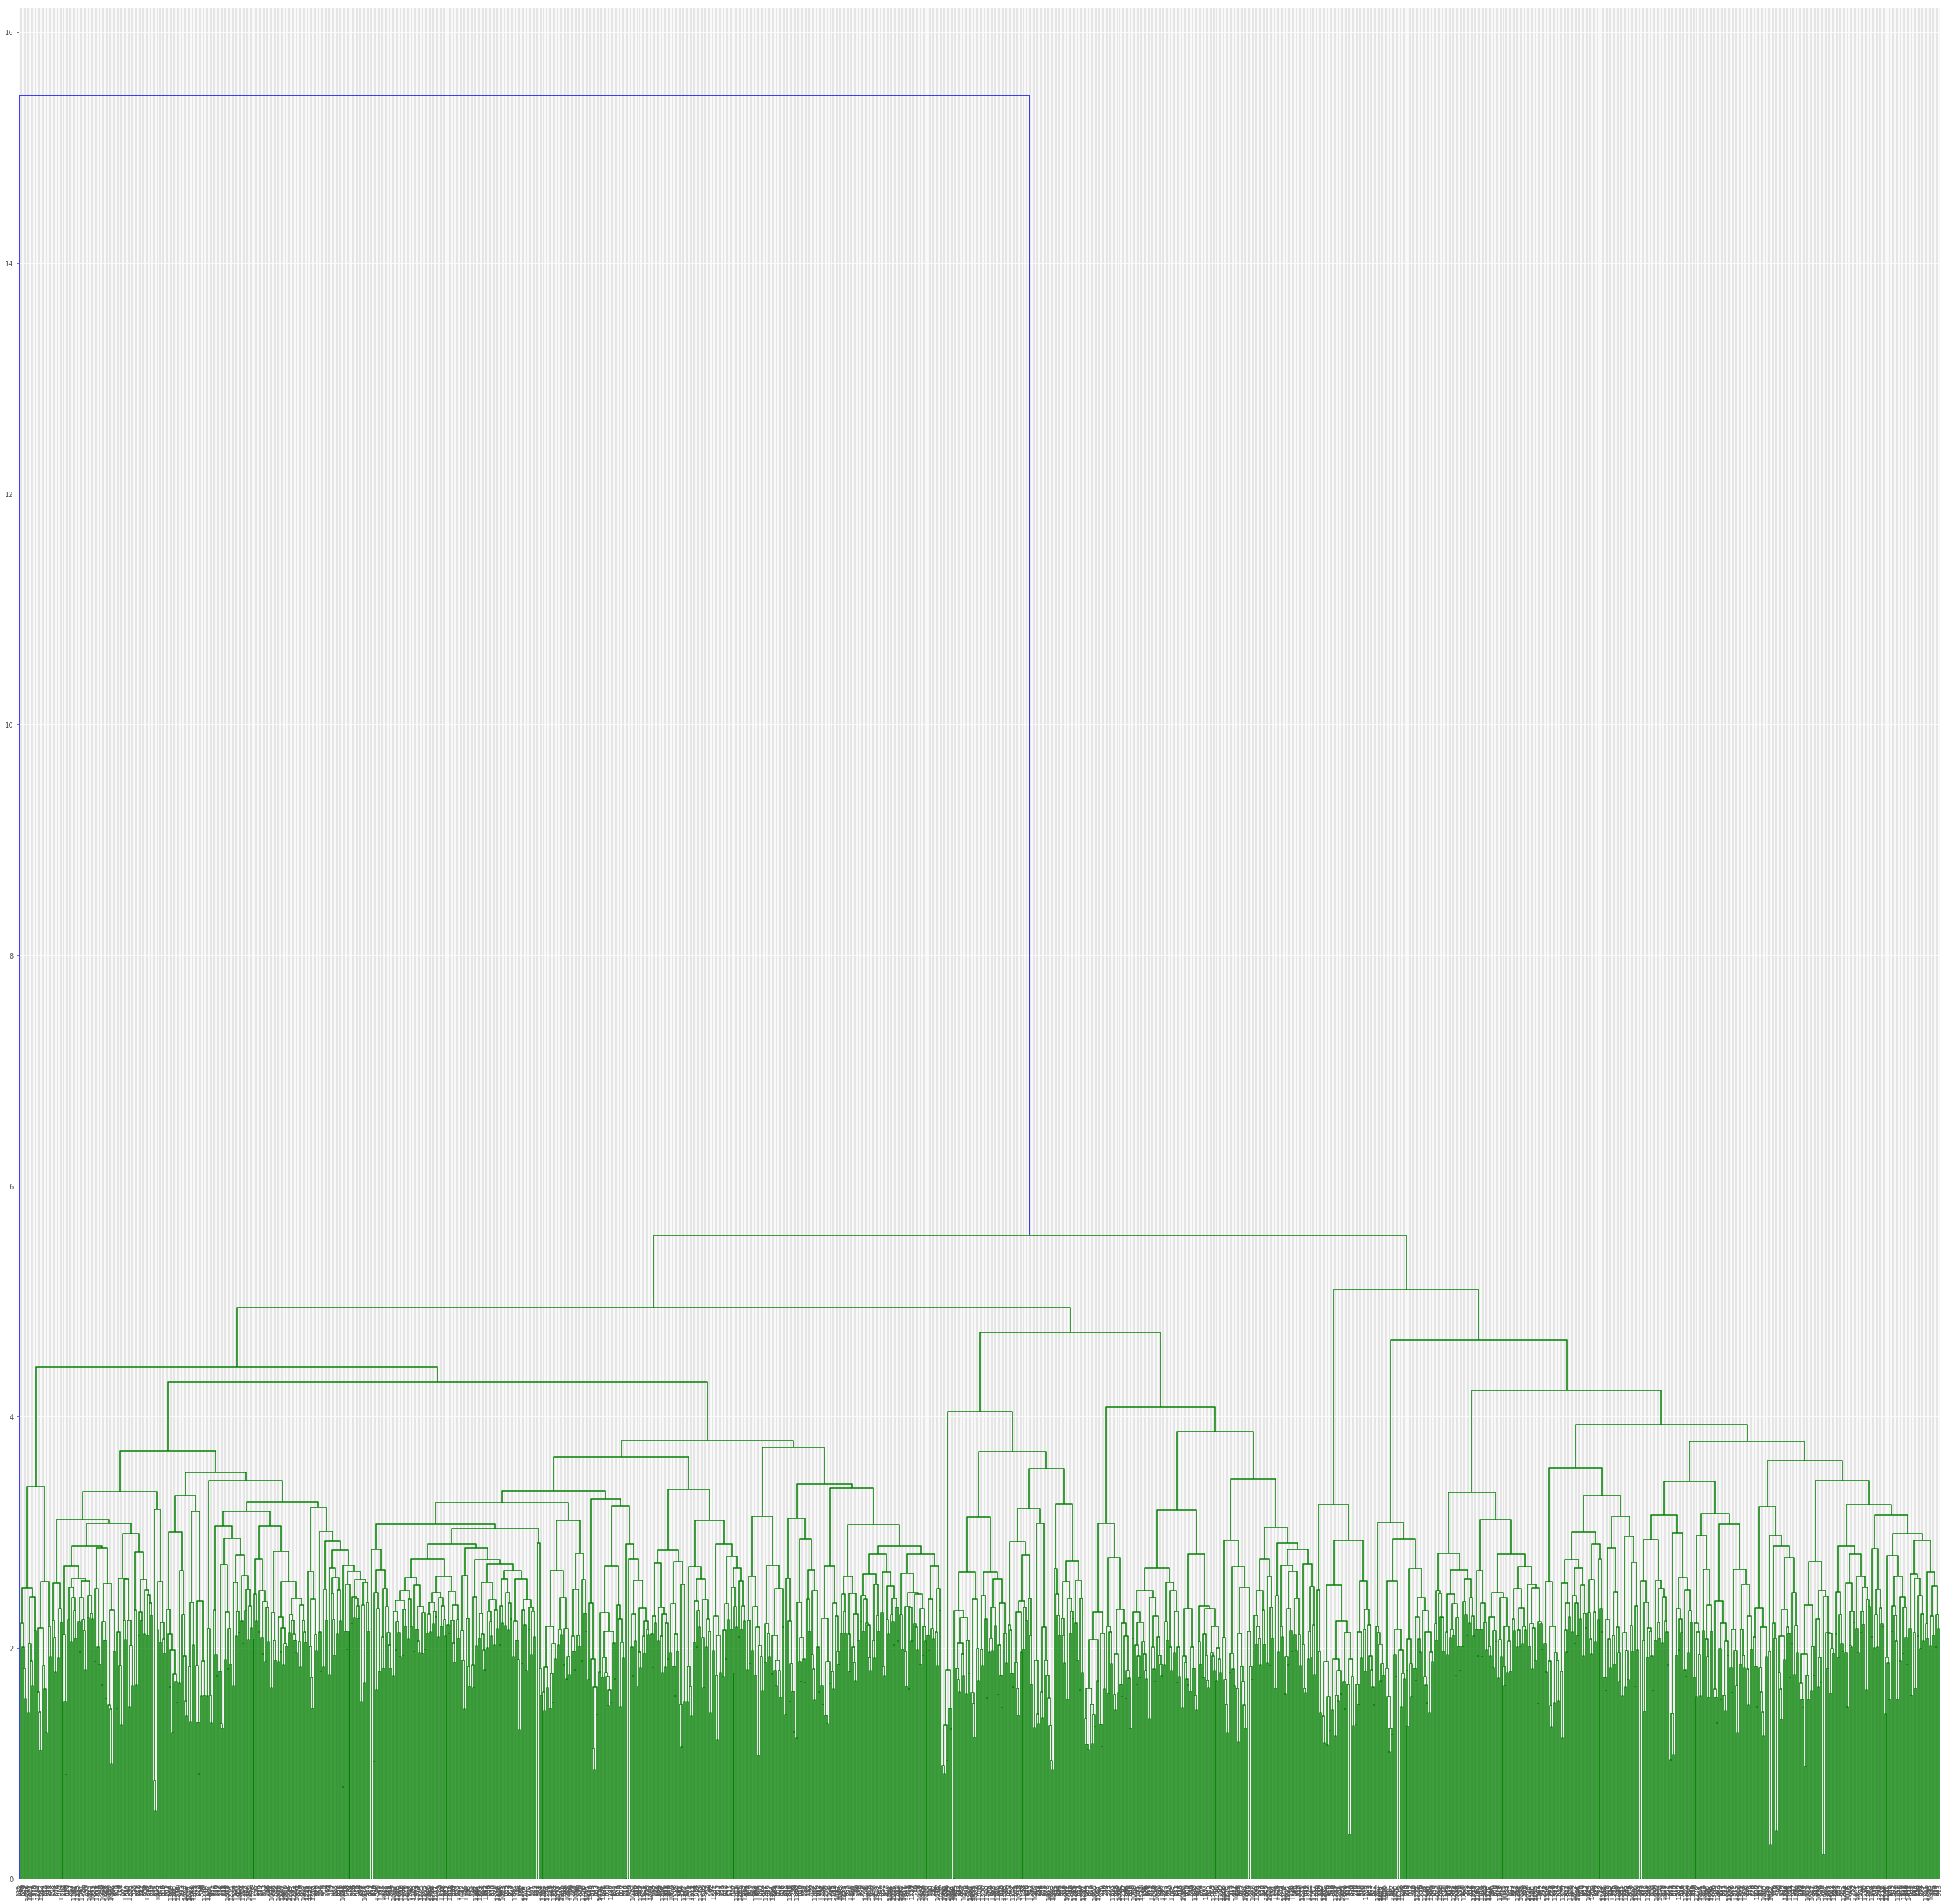

In [211]:
fig, axes = plt.subplots(1, figsize=(50,50))
_ = dendrogram(link, leaf_font_size=9)

In [190]:
warding = ward(dist)
warding.shape

(1404, 4)

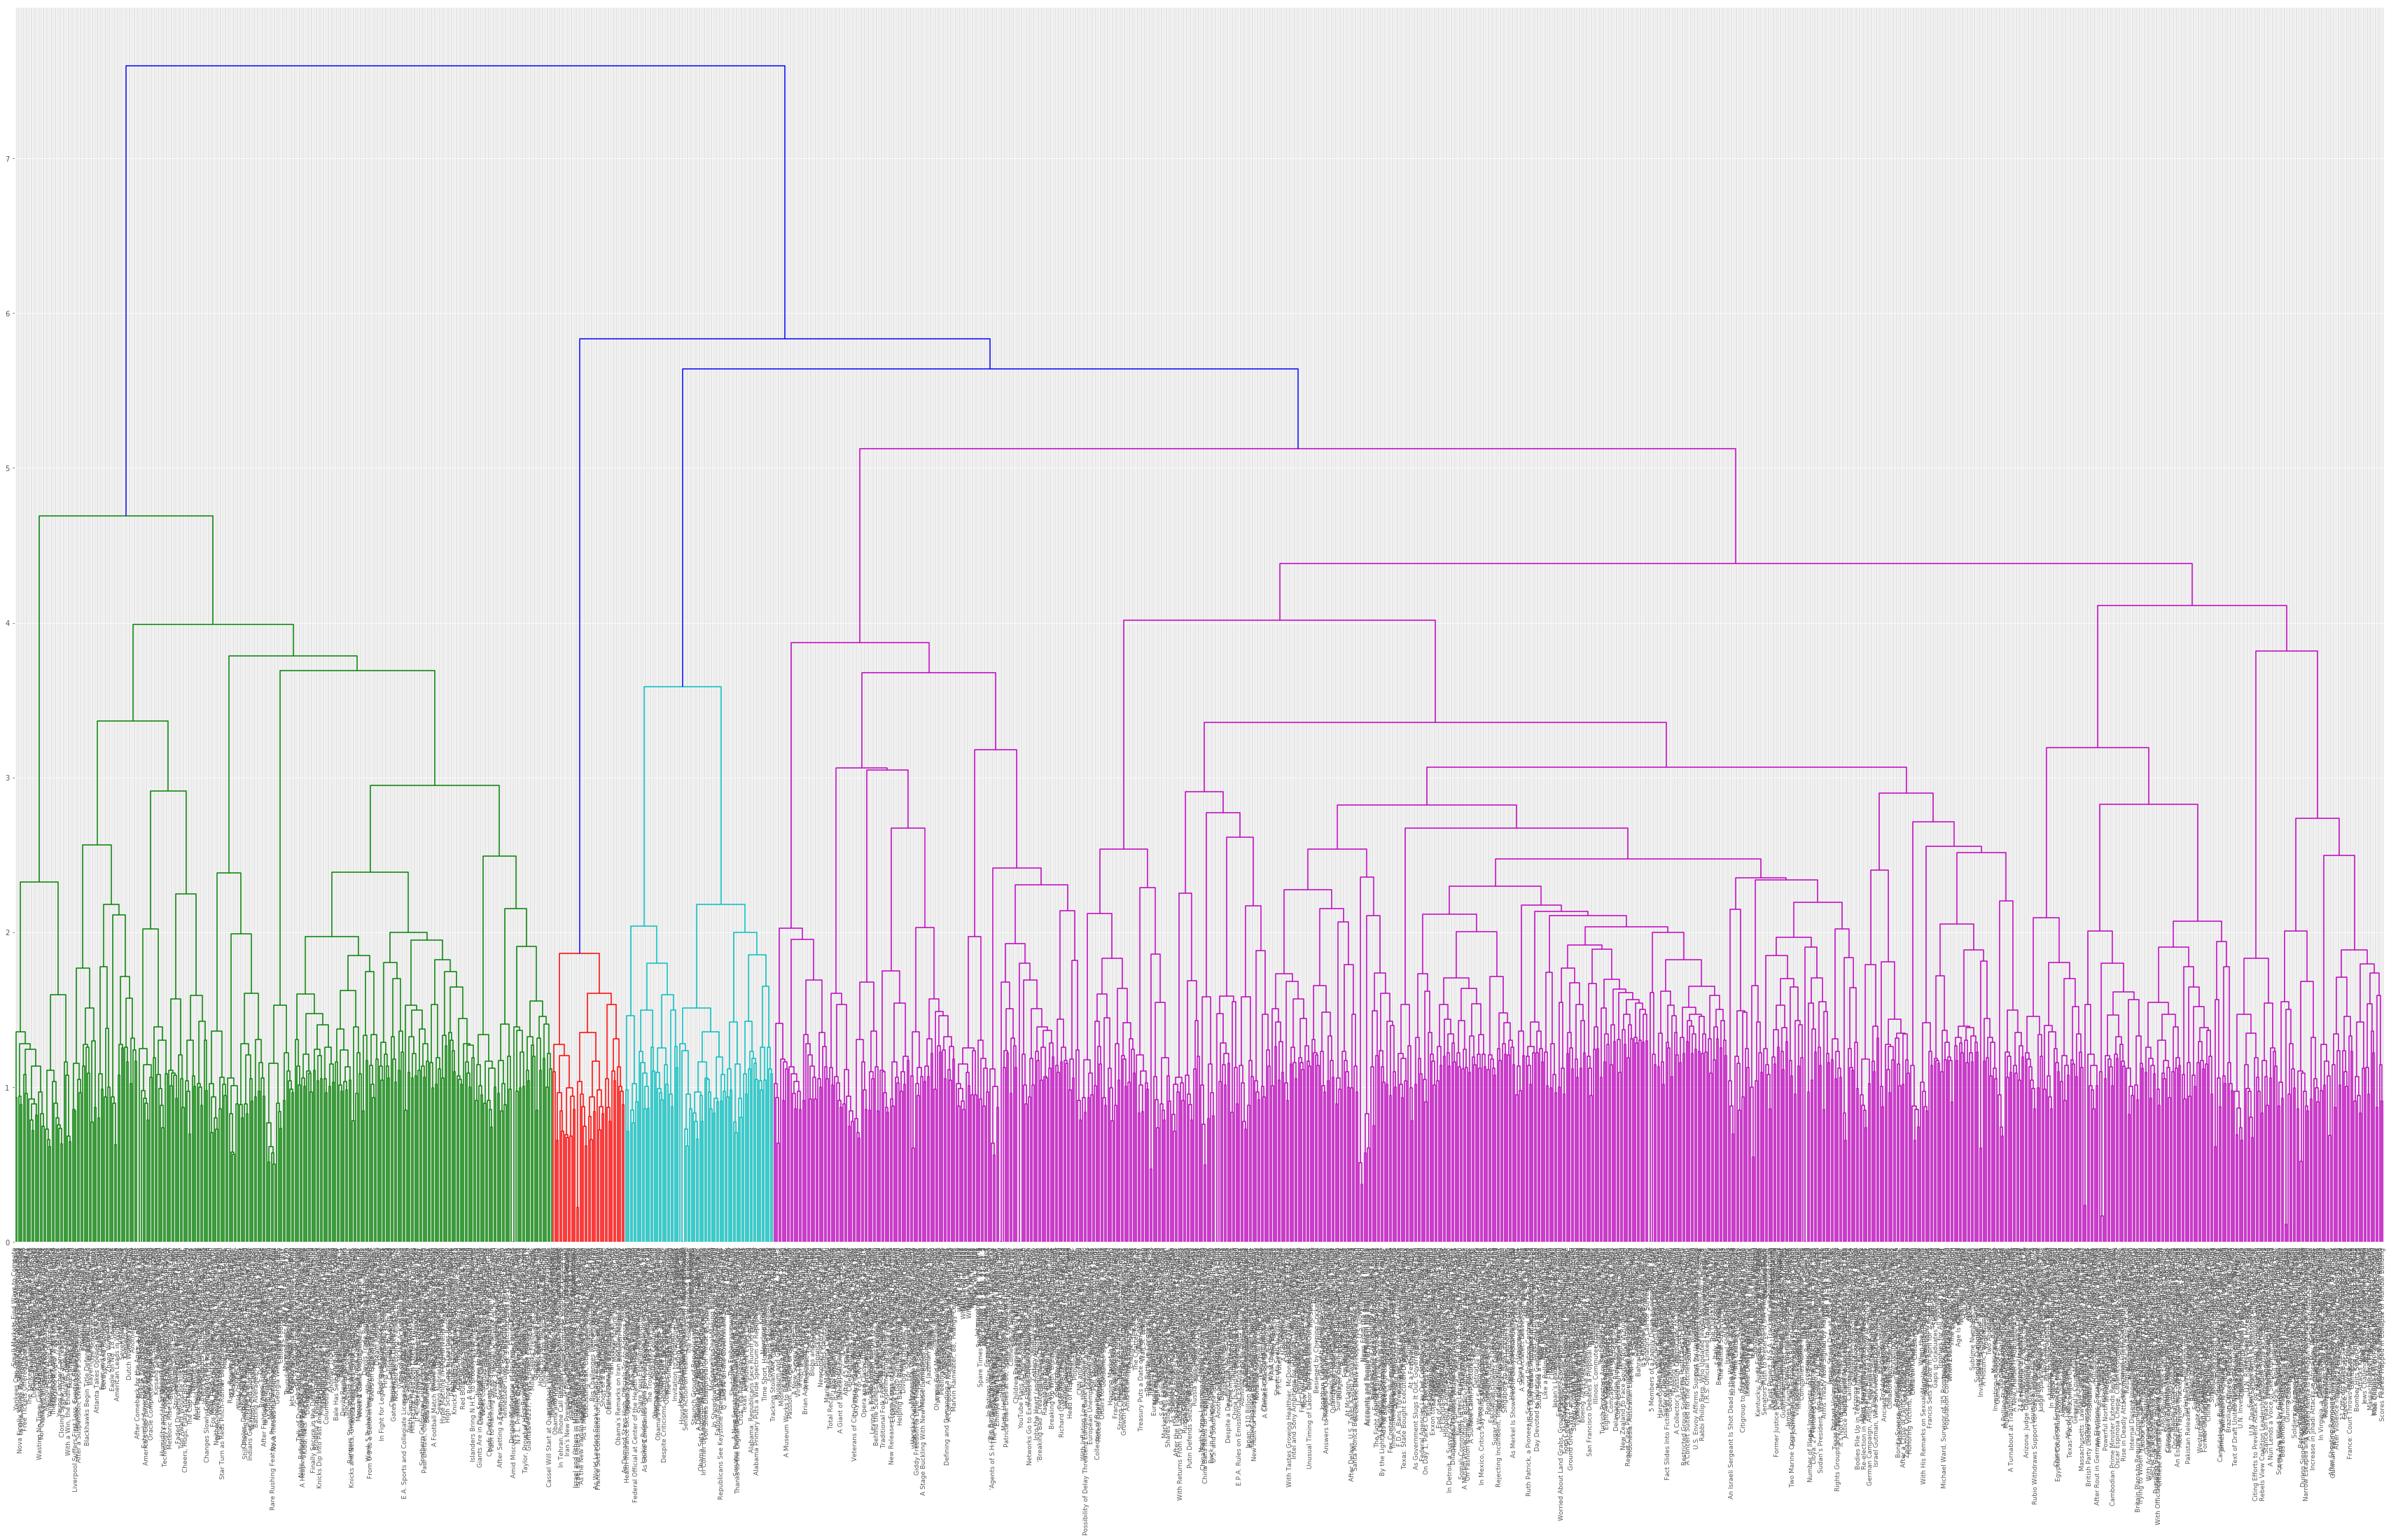

In [223]:
fig, ax = plt.subplots(1, figsize=(50,50))
dendrogram(warding,leaf_font_size=9,labels=df_original['headline'].values)
plt.subplots_adjust(top=.99, bottom=0.5, left=0.05, right=0.99)
plt.savefig('/home/asus/image.png')


### Hierarchical Topics
Now that we have our dendrogram we can begin exploring the clusters it has made.


1. To make your clusters more interpretable, change the labels on the data to be the titles of the articles. Can you find any interesting clusters or discover any topics not present in the NYT sections?  Are there any overlaps with the Kmeans topics and the hierarchical topics?


2. In addition, we might also be interested in how these hierarchical clusters compare to the NYT sections.  Label each point not only with the title but also the NYT section it belongs to.  Do any cross section topics emerge?

7. Perform the same analysis as above and inspect the dendrogram with the words from the articles.  Anything you wouldn't expect?

/home/asus/.virtualenvs/gurus/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


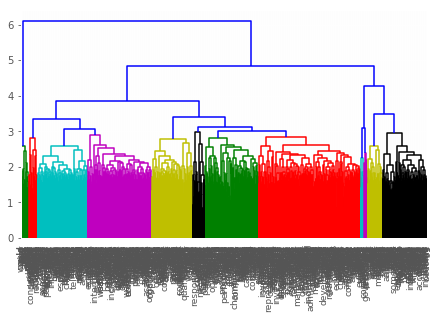

In [230]:
distxy_words = squareform(pdist(X.T.todense(), metric='cosine'))
dendro = dendrogram(linkage(distxy_words, method='complete'),
                    color_threshold=3, leaf_font_size=9,
                    labels=vocab)
plt.subplots_adjust(top=.99, bottom=0.2, left=0.05, right=0.99)
plt.show()